# NFL Punt Analytics Analysis
## Reducing Injuries while 
Rob Mulla

The NFL Punt Analytics Competition is being held by the NFL to elicit the public's proposal for rule modfications to punt rules. The goal being to reduce injuries.

Submissions will be judged by the NFL on the following criteria:

- **Solution Efficacy** - Have you clearly demonstrated, through your data analysis, that you have an understanding of what play features may be associated with concussions and how your proposed rule change(s) will reduce these injuries? Your kernels should be easy to understand and the analysis should be reproducible.  
- **Game Integrity** - Is your proposal actionable by the NFL? Could they implement your rule change and still maintain the integrity of the game? Have you considered the way your proposed changes to game dynamics could introduce new risks to player safety? Strong submissions will demonstrate an understanding for the game overall.

## Outline
1. **Data Analysis of All Punts**
    - What types of punts are common
    - What distance
    - What are the common formations for punts and punt returns?
2. **Data Analysis of Punts resulting in injury**
    - Which players are commonly involved in injuries?
    - What are the types of returns which result in injuries?
        - Can we group these? (ie., fake punt, long return, quick return, etc.)
    - What are the speed and velocity of players hurt?
3. **What are the routes run by player types?**
4. **What are possible changes to rules- how do they impact the plays?**
5. **My proposed rule changes**
    - How would they have changed the injuries?
    - How would they have changed the existing plays?

## Setup and Data Prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os

import bokeh        
from bokeh.io import show, output_notebook, push_notebook
from bokeh.layouts import row, column, widgetbox
from bokeh.plotting import figure
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
from bokeh.models import BoxAnnotation
from bokeh.models.widgets import Div
from bokeh.models.glyphs import Text

%matplotlib inline

In [2]:
# Read in non-NGS data sources
ppd = pd.read_csv('../input/player_punt_data.csv')
gd = pd.read_csv('../input/game_data.csv')
pprd = pd.read_csv('../input/play_player_role_data.csv')
vr = pd.read_csv('../input/video_review.csv')
vfi = pd.read_csv('../input/video_footage-injury.csv')
pi = pd.read_csv('../input/play_information.csv')

all_dfs = [ppd, gd, pprd, vr, vfi, pi]
for mydf in all_dfs:
    mydf.columns = [col.lower() for col in mydf.columns]

In [3]:
%%time
# Read in NGS data and combine.
# First try to read parquet file if it exists
def load_NGS_df(path = "../input/"):
    
    # gets all csv with NGS in their filename
    NGS_csvs = [path+file for file in os.listdir(path) if 'NGS' in file]
    
    df = pd.DataFrame() #initialize an empty dataframe
    
    # loop to csv then appends it to df
    for path_csv in NGS_csvs:
        _df = pd.read_csv(path_csv,low_memory=False)
        df = df.append(_df,ignore_index=True)
        del _df # deletes the _df to free up memory
        
    return df

try:
    ngs = pd.read_parquet('../input/ngs_combined_with_role_lssnap.parquet')
except:
    print('No parquet file- reading from CSVs')
    ngs = load_NGS_df()
    ngs = pd.merge(ngs, pprd) # Merge player position data
    ngs.columns = [col.lower() for col in ngs.columns]
    # Add rows for long snapper position at snap (for reference x,y)
    ngs_ls_at_snap = ngs.loc[(ngs['event'] == 'ball_snap') &
                         (ngs['role'] == 'PLS')]
    
    ngs = pd.merge(ngs,
               ngs_ls_at_snap[['season_year','gamekey','playid','time','x','y']],
               on=['season_year','gamekey','playid'],
               how='left',
               suffixes=('','_ls_at_snap'))
    ngs.to_parquet('../input/ngs_combined_with_role_lssnap.parquet')

CPU times: user 13.1 s, sys: 14.7 s, total: 27.7 s
Wall time: 1min 59s


In [4]:
# Detailed role info
role_info_dict = {'GL': ['Gunner', 'Punting_Team'],
             'GLi': ['Gunner', 'Punting_Team'],
             'GLo': ['Gunner', 'Punting_Team'],
             'GR': ['Gunner', 'Punting_Team'],
             'GRi': ['Gunner', 'Punting_Team'],
             'GRo': ['Gunner', 'Punting_Team'],
             'P': ['Punter', 'Punting_Team'],
             'PC': ['Punter_Protector', 'Punting_Team'],
             'PPR': ['Punter_Protector', 'Punting_Team'],
             'PPRi': ['Punter_Protector', 'Punting_Team'],
             'PPRo': ['Punter_Protector', 'Punting_Team'],
             'PDL1': ['Defensive_Lineman', 'Returning_Team'],
             'PDL2': ['Defensive_Lineman', 'Returning_Team'],
             'PDL3': ['Defensive_Lineman', 'Returning_Team'],
             'PDR1': ['Defensive_Lineman', 'Returning_Team'],
             'PDR2': ['Defensive_Lineman', 'Returning_Team'],
             'PDR3': ['Defensive_Lineman', 'Returning_Team'],
             'PDL5': ['Defensive_Lineman', 'Returning_Team'],
             'PDL6': ['Defensive_Lineman', 'Returning_Team'],
             'PFB': ['PuntFullBack', 'Punting_Team'],
             'PLG': ['Punting_Lineman', 'Punting_Team'],
             'PLL': ['Defensive_Backer', 'Returning_Team'],
             'PLL1': ['Defensive_Backer', 'Returning_Team'],
             'PLL3': ['Defensive_Backer', 'Returning_Team'],
             'PLS': ['Punting_Longsnapper', 'Punting_Team'],
             'PLT': ['Punting_Lineman', 'Punting_Team'],
             'PLW': ['Punting_Wing', 'Punting_Team'],
             'PRW': ['Punting_Wing', 'Punting_Team'],
             'PR': ['Punt_Returner', 'Returning_Team'],
             'PRG': ['Punting_Lineman', 'Punting_Team'],
             'PRT': ['Punting_Lineman', 'Punting_Team'],
             'VLo': ['Jammer', 'Returning_Team'],
             'VR': ['Jammer', 'Returning_Team'],
             'VL': ['Jammer', 'Returning_Team'],
             'VRo': ['Jammer', 'Returning_Team'],
             'VRi': ['Jammer', 'Returning_Team'],
             'VLi': ['Jammer', 'Returning_Team'],
             'PPL': ['Punter_Protector', 'Punting_Team'],
             'PPLo': ['Punter_Protector', 'Punting_Team'],
             'PPLi': ['Punter_Protector', 'Punting_Team'],
             'PLR': ['Defensive_Backer', 'Returning_Team'],
             'PRRo': ['Defensive_Backer', 'Returning_Team'],
             'PDL4': ['Defensive_Lineman', 'Returning_Team'],
             'PDR4': ['Defensive_Lineman', 'Returning_Team'],
             'PLM': ['Defensive_Backer', 'Returning_Team'],
             'PLM1': ['Defensive_Backer', 'Returning_Team'],
             'PLR1': ['Defensive_Backer', 'Returning_Team'],
             'PLR2': ['Defensive_Backer', 'Returning_Team'],
             'PLR3': ['Defensive_Backer', 'Returning_Team'],
             'PLL2': ['Defensive_Backer', 'Returning_Team'],
             'PDM': ['Defensive_Lineman', 'Returning_Team'],
             'PDR5': ['Defensive_Lineman', 'Returning_Team'],
             'PDR6': ['Defensive_Lineman', 'Returning_Team'],
             }
role_info = pd.DataFrame.from_dict(role_info_dict, orient='index', columns=['generalized_role','punting_returning_team']).reset_index().rename(columns={'index' : 'role'})
#ngs = pd.merge(ngs, role_info, how='left')

# Types of Punting Plays
6681 Different Plays provided information.

## Penalties
- 1077 Plays with Penalties (16.1%)
- Multiple Penalties:
    - 1038 plays have 1 type of penalty, 38 have 2 types of pentalties, and 1 play has 3 types of penalties.
- Most common penalty is `Offensive Holding` 442 of plays (6.6% of all punting plays) result in **Offensive Holding**
- **Illegal Blocking Above the Waist** is second most common penalty with 227 (3.39% of all punting plays)
- 243 plays (3.63% of punting plays) ended up not actually counting - ie a `No Play`
- 16 Plays were reviewed and had the call of field REVERSED
- 99 penalties declined
- There was a punting play with 5 total penalties! https://www.ninersnation.com/2017/8/19/16175124/referee-laughs-five-penalties-49ers-broncos-punt-pete-morelli

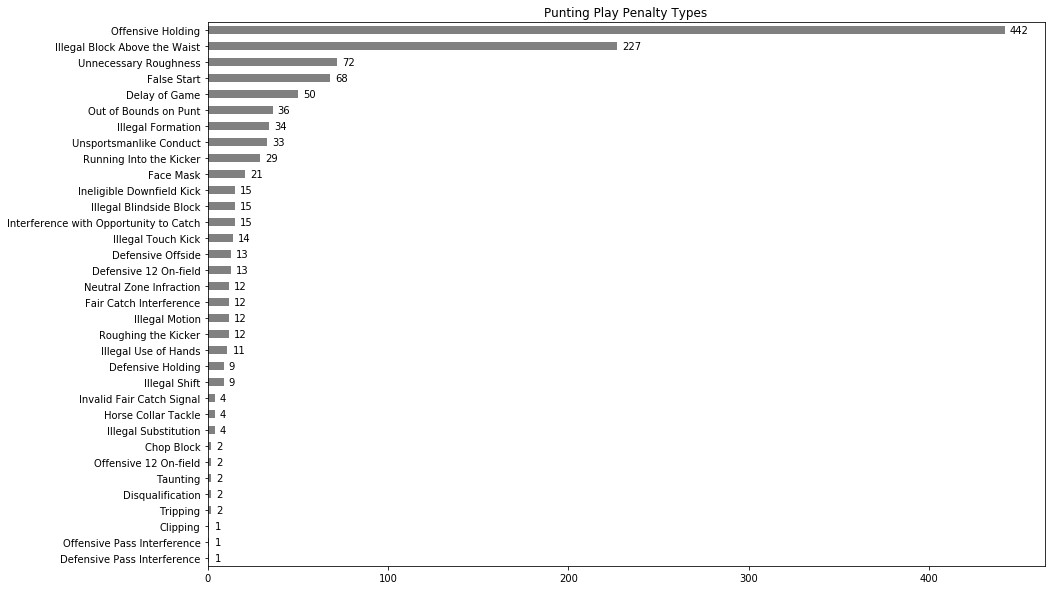

In [5]:
# Penalties

penalties_list = ['Offensive Holding', 'Defensive 12 On-field', 'Illegal Block Above the Waist', 'Fair Catch Interference',
                  'Running Into the Kicker', 'Unnecessary Roughness', 'Illegal Touch Kick',
                  'Illegal Use of Hands', 'False Start', 'Out of Bounds on Punt', 'Horse Collar Tackle',
                  'Face Mask', 'Ineligible Downfield Kick', 'Illegal Substitution', 'Illegal Formation',
                  'Delay of Game', 'Illegal Blindside Block', 'Neutral Zone Infraction', 'Tripping',
                  'Defensive Holding', 'Roughing the Kicker', 'Unsportsmanlike Conduct', 'Defensive Offside',
                  'Interference with Opportunity to Catch', 'Illegal Motion', 'Chop Block', 'Clipping',
                  'Invalid Fair Catch Signal', 'Illegal Shift', 'Offensive 12 On-field', 'Taunting',
                  'Offensive Pass Interference', 'Disqualification', 'Defensive Pass Interference']

pi['PENALTY'] = (pi['playdescription'].str.contains('PENALTY') | pi['playdescription'].str.contains('Penalty'))
pi['declined'] = pi['playdescription'].str.contains('declined')


pi['Offensive Holding'] =  pi['playdescription'].str.contains('Offensive Holding')
pi['Defensive 12 On-field'] =  pi['playdescription'].str.contains('Defensive 12 On-field')
pi['Illegal Block Above the Waist'] =  pi['playdescription'].str.contains('Illegal Block Above the Waist')
pi['Fair Catch Interference'] = pi['playdescription'].str.contains('Fair Catch Interference')
pi['Running Into the Kicker'] = pi['playdescription'].str.contains('Running Into the Kicker')
pi['Unnecessary Roughness'] = pi['playdescription'].str.contains('Unnecessary Roughness')
pi['Illegal Touch Kick'] = pi['playdescription'].str.contains('Illegal Touch Kick')
pi['Illegal Use of Hands'] = pi['playdescription'].str.contains('Illegal Use of Hands')
pi['False Start'] = pi['playdescription'].str.contains('False Start')
pi['Out of Bounds on Punt'] = pi['playdescription'].str.contains('Out of Bounds on Punt')
pi['Horse Collar Tackle'] = pi['playdescription'].str.contains('Horse Collar Tackle')
pi['Face Mask'] = pi['playdescription'].str.contains('Face Mask')
pi['Ineligible Downfield Kick'] = pi['playdescription'].str.contains('Ineligible Downfield Kick')
pi['Illegal Substitution'] = pi['playdescription'].str.contains('Illegal Substitution')
pi['Illegal Formation'] = pi['playdescription'].str.contains('Illegal Formation')
pi['Delay of Game'] = pi['playdescription'].str.contains('Delay of Game')
pi['Illegal Blindside Block'] = pi['playdescription'].str.contains('Illegal Blindside Block')
pi['Neutral Zone Infraction'] = pi['playdescription'].str.contains('Neutral Zone Infraction')
pi['Tripping'] = pi['playdescription'].str.contains('Tripping')
pi['Defensive Holding'] = pi['playdescription'].str.contains('Defensive Holding')
pi['Roughing the Kicker'] = pi['playdescription'].str.contains('Roughing the Kicker')
pi['Unsportsmanlike Conduct'] = pi['playdescription'].str.contains('Unsportsmanlike Conduct')
pi['Defensive Offside'] = pi['playdescription'].str.contains('Defensive Offside')
pi['Interference with Opportunity to Catch'] = pi['playdescription'].str.contains('Interference with Opportunity to Catch')
pi['Illegal Motion'] = pi['playdescription'].str.contains('Illegal Motion')
pi['Chop Block'] = pi['playdescription'].str.contains('Chop Block')
pi['Clipping'] = pi['playdescription'].str.contains('Clipping')
pi['Invalid Fair Catch Signal'] = pi['playdescription'].str.contains('Invalid Fair Catch Signal')
pi['Illegal Shift'] = pi['playdescription'].str.contains('Illegal Shift')
pi['Offensive 12 On-field'] = pi['playdescription'].str.contains('Offensive 12 On-field')
pi['Taunting'] = pi['playdescription'].str.contains('Taunting')
pi['Offensive Pass Interference'] = pi['playdescription'].str.contains('Offensive Pass Interference')
pi['Disqualification'] = pi['playdescription'].str.contains('Disqualification')
pi['Defensive Pass Interference'] = pi['playdescription'].str.contains('Defensive Pass Interference')

pi['count'] = 1

# Plot Penalties

ax = pi[penalties_list].sum() \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 10), color='grey', title='Punting Play Penalty Types')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

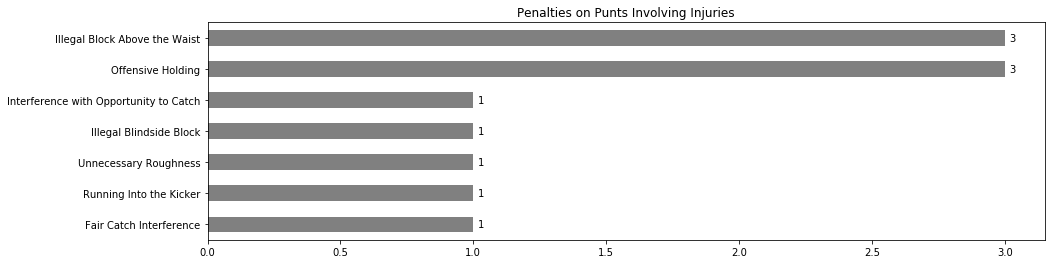

In [6]:
injury_plays = pd.merge(pi, vr)

ax = injury_plays[penalties_list].sum().loc[(injury_plays[penalties_list].sum() != 0)] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 4), color='grey', title='Penalties on Punts Involving Injuries')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

## No Plays (Penalty Causing the play not to count)

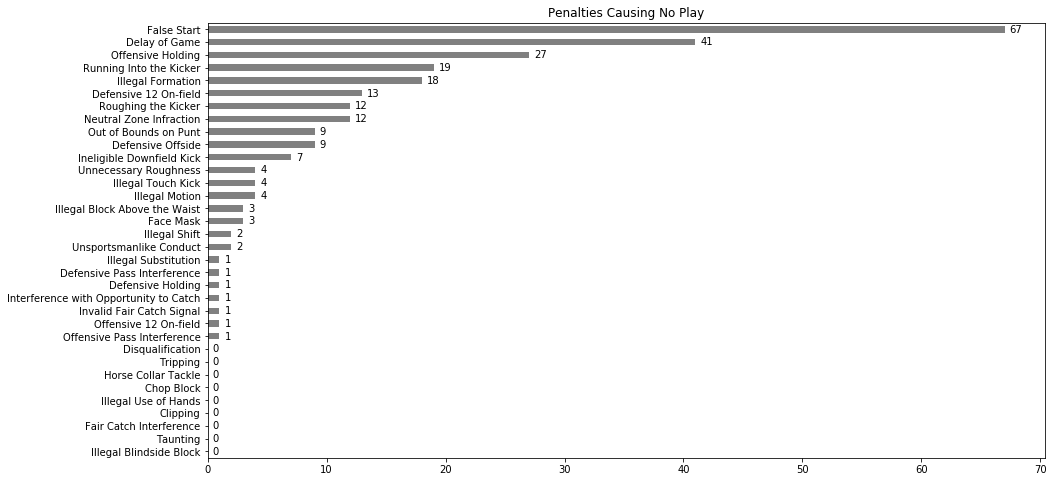

In [7]:
pi['No Play'] = pi['playdescription'].str.contains('No Play')
ax = pi[pi['No Play']][penalties_list].sum() \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), color='grey', title='Penalties Causing No Play')
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

## Reviewed / Reversed Plays
- 41 Punting plays had some sort of review.
    - 23 of the reviews were by challenge
    - 18 plays reviewed by the Replay Official
- 52.1% of challeneged plays were reversed
- 22.2% of reviewed by Replay Official reversed

In [8]:
pi['challenged'] = pi['playdescription'].str.contains('challenged')
pi['review'] = pi['playdescription'].str.contains('review')
pi['Upheld'] = pi['playdescription'].str.contains('Upheld')
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')

pi[pi['challenged'] | pi['review']] \
    .groupby(['challenged'])[['Upheld','REVERSED']] \
    .sum() \
    .sort_values('challenged', ascending=False)

,Upheld,REVERSED
challenged,,
True,11.0,12.0
False,14.0,4.0


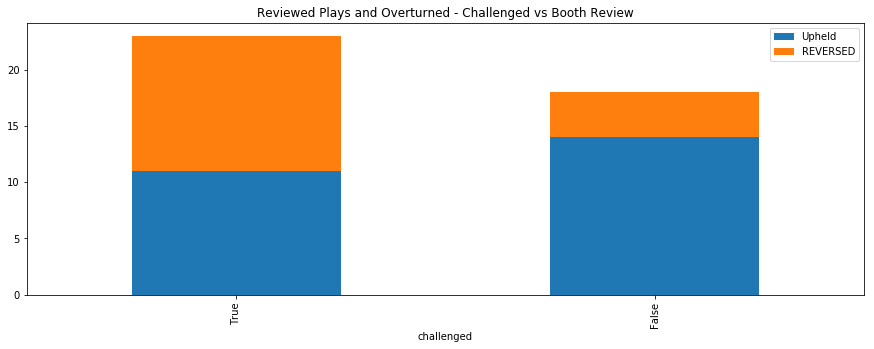

In [9]:
pi['challenged'] = pi['playdescription'].str.contains('challenged')
pi['review'] = pi['playdescription'].str.contains('review')
pi['Upheld'] = pi['playdescription'].str.contains('Upheld')
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')

pi[pi['challenged'] | pi['review']] \
    .groupby(['challenged'])[['Upheld','REVERSED']] \
    .sum() \
    .sort_values('challenged', ascending=False) \
    .plot(kind='bar', stacked='True', figsize=(15, 5), title='Reviewed Plays and Overturned - Challenged vs Booth Review')

plt.show()

# Fair Catch, Touchback, Out of Bounds or Returned

In [10]:
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')
pi['out of bounds'] = pi['playdescription'].str.contains('out of bounds')
pi['Touchback'] = pi['playdescription'].str.contains('Touchback')
pi['fair catch'] = pi['playdescription'].str.contains('fair catch')
pi['MUFF'] = pi['playdescription'].str.contains('MUFF')
pi['downed'] = pi['playdescription'].str.contains('downed')
pi['BLOCKED'] = pi['playdescription'].str.contains('BLOCKED')
pi['TOUCHDOWN'] = pi['playdescription'].str.contains('TOUCHDOWN')
pi['no gain'] = pi['playdescription'].str.contains('no gain')
pi['FUMBLES'] = pi['playdescription'].str.contains('FUMBLES')
pi['pass incomplete'] = pi['playdescription'].str.contains('pass incomplete')

pi['Returned'] = (~pi['No Play'] &
                    ~pi['out of bounds'] &
                    ~pi['Touchback'] &
                    ~pi['fair catch'] &
                    ~pi['downed'] &
                    ~pi['MUFF'] &
                    ~pi['BLOCKED'] &
                    ~pi['PENALTY'] &
                    ~pi['no gain'] &
                    ~pi['FUMBLES'] &
                    ~pi['pass incomplete'])

pi['returned for'] = pi[~pi['No Play'] &
                        ~pi['out of bounds'] &
                        ~pi['Touchback'] &
                        ~pi['fair catch'] &
                        ~pi['downed'] &
                        ~pi['MUFF'] &
                        ~pi['BLOCKED'] &
                        ~pi['PENALTY'] &
                        ~pi['no gain'] &
                        ~pi['FUMBLES'] &
                        ~pi['pass incomplete']]['playdescription'].str.extract('(for .* yard)', expand=True).fillna(False)

# Cleanup ugly retrun yards and get int
pi['return_yards'] = pi['returned for'].replace('for -2 yards. Lateral to C.Patterson to MIN 31 for 9 yards (W.Woodyard', 'for 9 yards') \
    .replace('for -4 yards. Lateral to R.Mostert to SEA 35 for 33 yard', 'for 33 yard') \
    .replace('for 10 yards (K.Byard', 'for 11 yard') \
    .replace('for 12 yards (A.Blake; W.Woodyard','for 12 yard') \
    .replace('for 14 yards (N.Palmer; K.Byard','for 14 yard') \
    .replace('for 44 yards (R.Blanton; C.Schmidt). Buffalo challenged the runner was in bounds ruling, and the play was REVERSED. C.Schmidt punts 35 yards to SEA 38, Center-G.Sanborn. T.Lockett ran ob at BUF 40 for 22 yard', 'for 22 yard') \
    .replace('for 2 yards (W.Woodyard','for 2 yard') \
    .replace('for -2 yards. Lateral to C.Patterson to MIN 31 for 9 yard','for 9 yard') \
    .replace('for 34 yards (C.Goodwin). Atlanta challenged the runner was in bounds ruling, and the play was REVERSED. M.Bosher punts 56 yards to NE 21, Center-J.Harris. J.Edelman ran ob at NE 47 for 26 yard', 'for 26 yard') \
    .dropna() \
    .str.replace('for ','').str.replace('yard','').astype('int')
# Zero return yards for 'no gain'
pi.loc[pi['no gain'], 'return_yards'] = 0

In [25]:
pi.loc[3400]['playdescription']

'(10:20) B.Pinion punts 56 yards to KC 26, Center-K.Nelson. D.Thomas pushed ob at KC 35 for 9 yards (D.Smelter). PENALTY on KC-J.March-Lillard, Offensive Holding, 10 yards, enforced at KC 27.'

In [22]:
pi[['Returned',
    'No Play',
    'out of bounds',
    'FUMBLES',
    'Touchback',
    'fair catch',
    'MUFF',
    'downed',
    'BLOCKED',
    'no gain',
    'pass incomplete']] \
    .sum(axis=1) \
    .sort_values()

3400    0
4069    0
2709    0
2708    0
827     0
828     0
5906    0
5905    0
834     0
2697    0
5900    0
2693    0
4088    0
4093    0
4097    0
4098    0
5874    0
2672    0
4108    0
875     0
4064    0
2716    0
2718    0
2719    0
718     0
5995    0
2781    0
737     0
739     0
2775    0
       ..
2172    2
2970    2
496     2
4662    2
3034    2
2077    2
3761    2
428     2
3025    2
2088    2
1433    2
3014    2
2092    2
6270    2
6223    2
0       2
4649    2
3795    2
465     2
2990    2
6243    2
479     2
4632    2
3811    2
6226    2
3785    2
3100    3
687     3
1815    3
1117    3
Length: 6681, dtype: int64

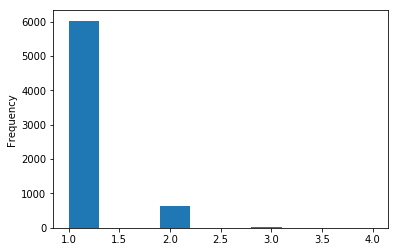

In [13]:
pi[['Returned',
    'PENALTY',
    'out of bounds',
    'FUMBLES',
    'Touchback',
    'fair catch',
    'MUFF',
    'downed',
    'BLOCKED',
    'no gain',
    'pass incomplete']] \
    .sum(axis=1) \
    .sort_values() \
    .plot(kind='hist')

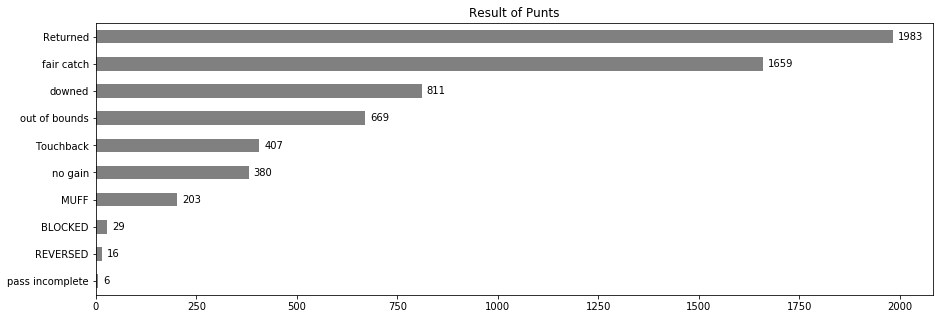

In [15]:
ax = pi[['Returned', 'REVERSED','out of bounds','Touchback','fair catch','MUFF','downed','BLOCKED','no gain','pass incomplete']] \
    .sum() \
    .sort_values(ascending=True) \
    .plot(kind='barh', color='grey', figsize=(15, 5), title='Result of Punts')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

# Typical Return Yards

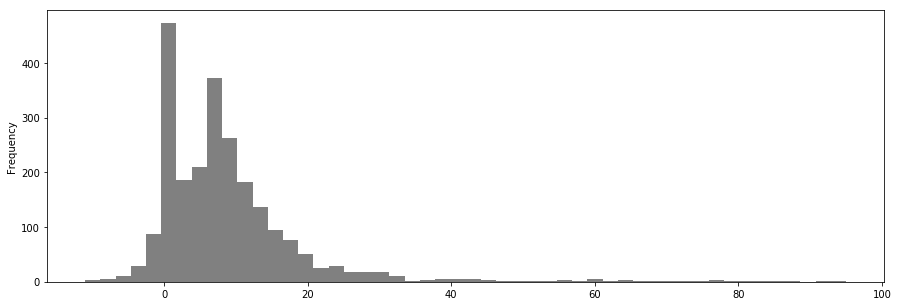

In [26]:
pi['return_yards'].plot(kind='hist', figsize=(15, 5), bins=50, color='grey')

In [42]:
pi['return_yards'].median()

7.0

In [43]:
pi['return_yards'].mean()

8.798561151079136

In [29]:
pi.head()

,season_year,season_type,gamekey,game_date,week,playid,game_clock,yardline,quarter,play_type,...,MUFF,downed,BLOCKED,TOUCHDOWN,no gain,FUMBLES,pass incomplete,Returned,returned for,return_yards
0,2016,Pre,2,08/13/2016,2,191,12:30,LA 47,1,Punt,...,False,True,False,False,False,False,False,False,NaN,NaN
1,2016,Pre,2,08/13/2016,2,1132,12:08,LA 29,2,Punt,...,False,False,False,False,False,False,False,False,NaN,NaN
2,2016,Pre,2,08/13/2016,2,1227,10:01,DAL 18,2,Punt,...,False,False,False,False,False,False,False,True,for 25 yard,25.0
3,2016,Pre,2,08/13/2016,2,1864,00:21,DAL 46,2,Punt,...,False,False,False,False,False,False,False,False,NaN,NaN
4,2016,Pre,2,08/13/2016,2,2247,10:26,DAL 15,3,Punt,...,False,False,False,False,False,False,False,False,NaN,NaN


# Plotting Plays Interactive

In [46]:
output_notebook()


playinfo = Div(text='Play info', width=200, height=100)

# Filter a sepcific play
season_year=2016
gamekey=21
playid=2587

play = ngs[(ngs['season_year'] == season_year) &
           (ngs['gamekey'] == gamekey) &
           (ngs['playid'] == playid)]

play = pd.merge(play, pprd)
playxy = play.drop(['season_year','gamekey'], axis=1) \
    .pivot(index='time',
           columns='role',
           values=['x','y','event'])

# Create colors
colors = ['red' if x in(vr['gsisid'].values) or x in(vr['primary_partner_gsisid'].values) else 'blue' for x in play.gsisid.unique()]

# Setup Figure
## Football Field Figure
fig = figure(plot_width=800, plot_height=400, x_range=(0,120), y_range=(0, 53.3))
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# Green Field
box = BoxAnnotation(left=0, right=120, fill_color='green', fill_alpha=0.5)
endzone1 = BoxAnnotation(left=0, right=10, fill_color='grey', fill_alpha=0.5)
endzone2 = BoxAnnotation(left=110, right=120, fill_color='grey', fill_alpha=0.5)
fig.add_layout(box)
fig.add_layout(endzone1)
fig.add_layout(endzone2)
# Add lines|
fig.line([10,10,20,20,30,30,40,40,50,50,60,60,70,70,80,80,90,90,
          100,100,110,110,120,120],
         [55.5,0,0,55.5,55.5,0,0,55.5,55.5,0,0,55.5,55.5,0,0,55.5,
         55.5,0,0,55.5,55.5,0,0,0], line_color='grey')
# Line numbers

line_nums = ColumnDataSource(dict(x=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                                  y=[5, 5, 5, 5, 5, 5, 5, 5, 5],
                                  text=['10', '20', '30','40','50','40','30','20','10']))
glyph = Text(x="x", y="y", text="text", angle=0, text_color="black", text_align='center')
fig.add_glyph(line_nums, glyph)

# Create values used in the initial states
x_values = playxy.loc[playxy.index[1]]['x'].values
y_values = playxy.loc[playxy.index[1]]['y'].values
gsisid = playxy['x'].columns.values
source = ColumnDataSource(data=dict(x=x_values,
                                    y=y_values,
                                    gsisid=gsisid))
labels = LabelSet(x='x', y='y', text='gsisid', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

# Add players as circles
plt = fig.circle(x_values, y_values, size=20, alpha=0.5, color=colors, radius=1)
fig.add_layout(labels)

def plot_time_pos(time_pos):
    x_values = playxy.loc[playxy.index[time_pos]]['x'].values
    y_values = playxy.loc[playxy.index[time_pos]]['y'].values
    gsisid = playxy['x'].columns.values
    # p = figure(plot_width=800, plot_height=400)
    # p.circle(x_values, y_values, size=20, color="navy", alpha=0.5)
    source = ColumnDataSource(data=dict(x=x_values,
                                    y=y_values,
                                    gsisid=gsisid))
    labels = LabelSet(x='x', y='y', text='gsisid', level='glyph',
               x_offset=5, y_offset=5, source=source, render_mode='canvas')
    fig.renderers.pop()
    fig.add_layout(labels)
    plt.data_source.data['x'] = x_values
    plt.data_source.data['y'] = y_values

    # Update text
    event = playxy.loc[playxy.index[time_pos]]['event'].values[0]
    playinfo.text = str(event)
    
    push_notebook(handle=bokeh_handle)


source = ColumnDataSource(data=dict(x=x_values, y=y_values))

callback = CustomJS(code="""
if (IPython.notebook.kernel !== undefined) {
    var kernel = IPython.notebook.kernel;
    cmd = "plot_time_pos(" + cb_obj.value + ")";
    kernel.execute(cmd, {}, {});
}
""")


slider = Slider(start=0,
                end=len(playxy),
                value=1,
                step=1,
                title="position within play",
                callback=callback)

layout = column(
    widgetbox(slider),
    fig,
    playinfo
)

bokeh_handle = show(layout, notebook_handle=True)

Loading BokehJS ...